# News Articles Recommendation

## 1. Collect Active Twitter Users' Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#to scrape Twitter
import tweepy
from tweepy import OAuthHandler
 
#warning    
import warnings
warnings.filterwarnings('ignore')

In [24]:
#authorizing twitter api with consumer key and secrets
consumer_key = 'bk0NOPDwa9n0uJfSDMf67hiyU'
consumer_secret = 'TeS01OB7CiMoOQP56MnGw1iQGZWW3d3Mz1V604bslINT1vtR6P'
access_token = '1123380505653784581-dCXq7AFYAd0OnjIJsR0edjHiLOM3Md'
access_secret = 'uHH5dkjNfxW8TZVejOWw5GAi7fsVbNM0PiTFwKjcgF7zH'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

We can get users who actively retweet news articles from popular news channels' twitter handles

In [25]:
def get_users(twitterNewsChannels,NumberofTweet):
    """This function fetch users who retweet given News handle's tweets 
    
    Input: 
      TwitterNewsChannels - List of news channels' twitter handles
      NumberofTweet = int number of tweet to analyze on this twitter handle
    Return:
      DataFrame of Users ActiveNewsReaders, Popularity, Verified, TotalTweets
      """
    usersFromTweets = pd.DataFrame(columns = ["ActiveNewsReaders","Popularity", "Verified","totalTweets"])
    numberOfUsersMined = 0
    
    for newsChannel in twitterNewsChannels:
        for tweet in api.user_timeline(screen_name = newsChannel, count=NumberofTweet):
            for reTweet in api.retweets(tweet.id):
                
                usersFromTweets.loc[numberOfUsersMined, "ActiveNewsReaders"] = reTweet.user.screen_name
                
                if(reTweet.user.friends_count == 0):
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count
                else:
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count/reTweet.user.friends_count
                
                usersFromTweets.loc[numberOfUsersMined, "Verified"] = reTweet.user.verified
                usersFromTweets.loc[numberOfUsersMined, "totalTweets"] = reTweet.user.statuses_count
                
                numberOfUsersMined+=  1
                
                if numberOfUsersMined %100 ==0:
        
                  time.sleep(6)
    return usersFromTweets

To fetch users, let's provide 3 news providers' twitter handles.
- New York Times - @nytimes
- CNN News - @CNN
- Washington Post - @washingtonpost

We will fetch the users who retweeted 50 top tweets of these news providers.

In [26]:
NewsChannelsUsernames = ["nytimes","CNN","washingtonpost"]
usersData = get_users(NewsChannelsUsernames, 25)

Let's see our active news readers

In [27]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets
0,Carmelbaptiste,0.578426,False,56373
1,Sd255180,0.211864,False,11951
2,WebbJimmie4,0.0375,False,11
3,SOBLUE_SOSUGAE,0.552448,False,1881
4,woundedamerican,0.80474,False,60331


In [28]:
# users might retweetted muliple tweets so, we removed the duplicate users
usersData.drop_duplicates(inplace = True)
usersData.shape

(962, 4)

To make sure that all users are authentic let's filter them based on their popularity and their twitter activity.

In [29]:
# Filetered users with tweets > 10 and popularity 
usersData = usersData[(usersData.totalTweets > 10) & (usersData.Popularity > 1)]
usersData.shape

(298, 4)

In [30]:
usersData = usersData.reset_index(drop=True)

Now we have list of active users from which we can get their information. Following function will extract each user's top 20 tweets

In [31]:
def getTweets(user):
    # Get Ten Tweets from the each user
    twitterUser = api.get_user(user)
    
    tweets = api.user_timeline(screen_name = user, count = 10,tweet_mode='extended')
    tentweets = []
    for tweet in tweets:
        if tweet.full_text.startswith("RT @") == True:
            tentweets.append(tweet.retweeted_status.full_text)
        else:
            tentweets.append(tweet.full_text)
       
    return tentweets

In [32]:
vfunc = np.vectorize(getTweets)
usersData["tweets"] = usersData['ActiveNewsReaders'].apply(lambda x: getTweets(x))

In [33]:
usersData.head(10)

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets
0,Tati_WM,1.81682,False,20653,[This emboldens anyone who doesn’t like a prot...
1,abbygoldgirl,2.45337,False,52207,[Hospitals and insurers negotiate over prices ...
2,maryjamer,1.02929,False,2542,"[Where does it end? https://t.co/gpKkCXh4dW, H..."
3,patstagepage,1.68635,False,86288,[A project is coming from Netflix on the rescu...
4,shammyzzz,2.42585,False,169725,"[#AWANInews [GAYA HIDUP] \nWow, Bahasa Malaysi..."
5,dhiyaapuspita,1.22222,False,12521,[A project is coming from Netflix on the rescu...
6,BillEsteem,1.0029,False,12210,[This is exactly why we do it. Thank you to e...
7,amanimoh16,1.04724,False,5003,"[Tornado damage reported in Bergman, Arkansas ..."
8,ohiomary,2.40728,False,297575,"[""The lights below and the moon above give the..."
9,trezz821,1.50596,False,37200,[2 people were fatally shot and at least 4 oth...


Since, the tweets are not clean we will have to preprocess them.

## 2. Analyze Users' Tweets

In [34]:
#to preprocess tweets
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
def processTweets(tweets):
    
    #cleaning of tweets
    cleanedTweets = []
    for tweet in tweets:
        tw = re.sub('http\S+', '', tweet) #remove links
        tw = re.sub('RT', '', tw) #remove RT of retweet
        tw = re.sub('@[^\s]+','',tw) #remove usernames 
        tw = "".join([char for char in tw if char not in string.punctuation]) #remove punctuations
        tw = tw.lower() #converting to lowercase letters
        tw = ' '.join([word for word in tw.split() if word not in (stop)]) #removing stop words
        tw = ' '.join([word for word in tw.split() if len(word)>2])
        cleanedTweets.append(tw)

    cleanedTweets = ' '.join(cleanedTweets) #joining all tweets
    
    #tokenization
    ProcessedTweets = nltk.word_tokenize(cleanedTweets) ####################################################
    
    #stemming
    ProcessedTweets = [ps.stem(word) for word in ProcessedTweets]
    
    #lammitization
    ProcessedTweets = [wn.lemmatize(word) for word in ProcessedTweets]
    
    ProcessedTweets = [word for word in ProcessedTweets if len(word)>2]
    
    ProcessedTweets = ' '.join(w for w in ProcessedTweets if w in words)
    
    return ProcessedTweets
        

In [36]:
usersData["ptweets"] = usersData['tweets'].apply(lambda x : processTweets(x))

In [37]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets,ptweets
0,Tati_WM,1.81682,False,20653,[This emboldens anyone who doesn’t like a prot...,embolden like protest sue organ action actual ...
1,abbygoldgirl,2.45337,False,52207,[Hospitals and insurers negotiate over prices ...,price don want competitor know deal they cut p...
2,maryjamer,1.02929,False,2542,"[Where does it end? https://t.co/gpKkCXh4dW, H...",end price don want competitor know deal they c...
3,patstagepage,1.68635,False,86288,[A project is coming from Netflix on the rescu...,project come boy soccer coach cave last year d...
4,shammyzzz,2.42585,False,169725,"[#AWANInews [GAYA HIDUP] \nWow, Bahasa Malaysi...",wow yang project come boy soccer coach cave la...


## 3. Cluster users according to their interests

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os

import matplotlib.pyplot as plt

To cluster users based on their twitter contents we need to convert tweets into vectorized form

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(usersData.ptweets)

In [40]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.24801342,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.17760415,
        0.        ],
       ...,
       [0.        , 0.16559834, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13706905, 0.        , ..., 0.120157  , 0.10613805,
        0.        ],
       [0.        , 0.        , 0.29707932, ..., 0.        , 0.11392602,
        0.        ]])

Let's see the Tf-Idf matrix with readers and words

In [41]:
tfidf_matrix.shape

(298, 126)

In [42]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = usersData.ActiveNewsReaders)

,act,allow,also,appear,ask,attorney,back,bill,break,call,...,well,white,without,woman,work,world,would,wrote,year,you
ActiveNewsReaders,,,,,,,,,,,,,,,,,,,,,
Tati_WM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.521051,0.000000,0.000000,0.000000,0.000000,0.248013,0.000000
abbygoldgirl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
maryjamer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.159147,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.177604,0.000000
patstagepage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185682,0.174274,0.000000,0.000000,...,0.192299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455071,0.000000
shammyzzz,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.264119,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.210797,0.000000,0.000000,0.000000,0.215768,0.000000
dhiyaapuspita,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.237559,0.312775
BillEsteem,0.000000,0.000000,0.000000,0.182645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.210872,0.000000,0.161025,0.000000,0.000000,0.000000,0.000000,0.217009
amanimoh16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.334995,0.000000
ohiomary,0.000000,0.000000,0.000000,0.000000,0.000000,0.145684,0.000000,0.000000,0.286892,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.156394,0.000000,0.000000,0.000000,0.160082,0.000000


Using this generated Tf-Idf matrix we can cluster the users.

In [43]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [44]:
km.cluster_centers_.argsort()[:, ::-1]

array([[119,  58,  50,  44, 117,  47, 103,  83, 102, 124,  86,  59, 110,
         31,  66,  34,  12,  43,  52,  68,  65, 105,  99,  24,  64,  10,
         72,  84,  42, 122,  78,  57,  92, 125,  28,  20,  22,  80,  61,
        100,   9,   2,  63,  89,   4, 111, 113,  17,  54, 116,  25,  94,
         53,   8,  11,  56, 106,  88,  46, 123,  74,  37,  27,  97,  40,
         60,  91, 115, 120,  38,  67,  26, 107, 121,  51, 112,   0,  30,
         85, 114,   6,   3,  95,  49,  81,  79,  41, 109,   1,  36,  96,
         93,  29,  48,  70,  73,  33,  98, 101,  69,  13, 118,   5,  77,
         35, 104,  15,  71,  62,  16,  39,  14,  55,  23,   7,  82,  45,
         75, 108,  19,  87,  76,  18,  32,  21,  90],
       [107,  48,  78,   5,  49,  84,  18,  90,  30,  15,   8,  76,  41,
         95,  83,  50,  62,  71,  43,  16,   7,  38,  79,  70,  22,   3,
         45,  23,  64,  11, 104,   9, 123,  67, 120,  31,  13,  56, 112,
        105, 122,  87, 108,  80,  72, 117,  63,   2,  92,  26, 102,  2

In [45]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 woman
 may
 like
 last
 white
 let
 today
 said
 time
 year
Cluster 1:
 trump
 letter
 report
 attorney
 lie
 say
 counsel
 special
 find
 congress
Cluster 2:
 one
 get
 time
 new
 year
 live
 like
 trump
 good
 work
Cluster 3:
 maduro
 need
 call
 world
 here
 know
 sen
 democrat
 talk
 get
Cluster 4:
 shoot
 north
 dead
 two
 say
 break
 school
 person
 one
 report


To reduce the dimension of Tf-Idf matrix we define error term, distance matrix using cosine similarity

In [46]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ 0.00000000e+00,  7.79038698e-01,  7.63261578e-01, ...,
         9.32344068e-01,  9.16861864e-01,  9.24134766e-01],
       [ 7.79038698e-01, -4.44089210e-16,  5.53175569e-01, ...,
         9.10987091e-01,  9.13033068e-01,  8.60035705e-01],
       [ 7.63261578e-01,  5.53175569e-01,  0.00000000e+00, ...,
         9.36948903e-01,  9.29374051e-01,  9.28062287e-01],
       ...,
       [ 9.32344068e-01,  9.10987091e-01,  9.36948903e-01, ...,
         0.00000000e+00,  5.12317121e-01,  5.29895513e-01],
       [ 9.16861864e-01,  9.13033068e-01,  9.29374051e-01, ...,
         5.12317121e-01, -2.22044605e-16,  7.22849288e-01],
       [ 9.24134766e-01,  8.60035705e-01,  9.28062287e-01, ...,
         5.29895513e-01,  7.22849288e-01,  0.00000000e+00]])

In [47]:
titles = usersData.ActiveNewsReaders

Here, we have used Manifold learning for vizualization. High-dimensional datasets can be very difficult to visualize. While data in two or three dimensions can be plotted to show the inherent structure of the data, equivalent high-dimensional plots are much less intuitive. To aid visualization of the structure of a dataset, the dimension must be reduced in some way.

The simplest way to accomplish this dimensionality reduction is by taking a random projection of the data. Though this allows some degree of visualization of the data structure, the randomness of the choice leaves much to be desired. In a random projection, it is likely that the more interesting structure within the data will be lost.

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

In [48]:
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

Plotting users based on their clusters

In [49]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

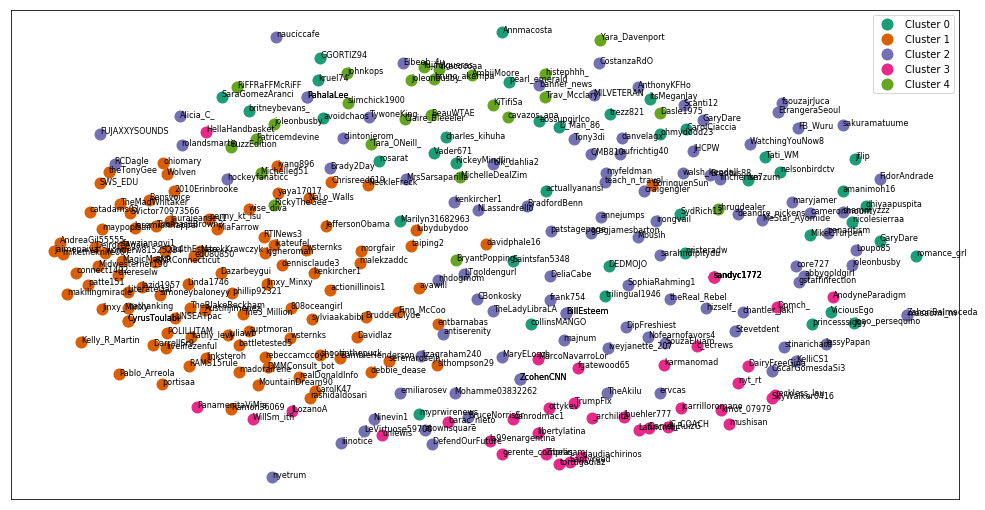

In [50]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

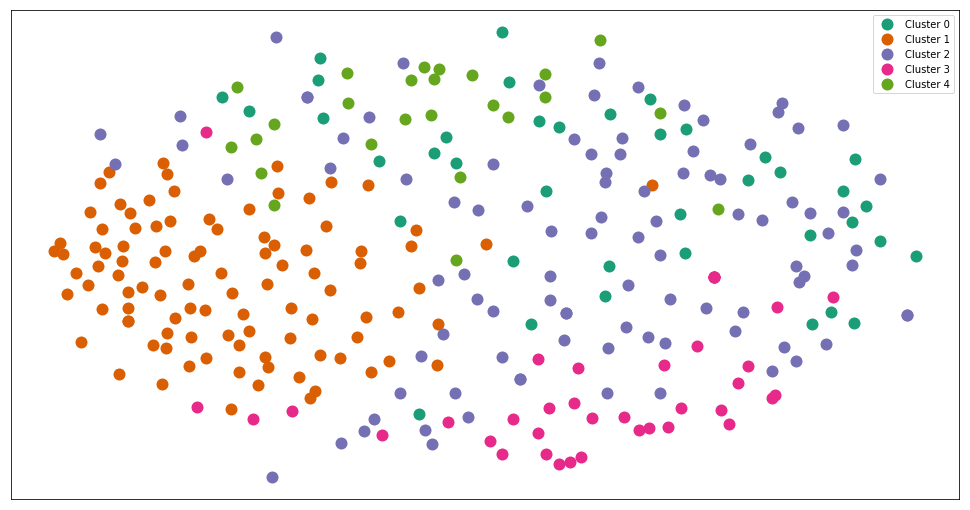

In [51]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [52]:
#adding cluster labels in the usersData 
usersData['cluster'] = clusters

In [53]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets,ptweets,cluster
0,Tati_WM,1.81682,False,20653,[This emboldens anyone who doesn’t like a prot...,embolden like protest sue organ action actual ...,0
1,abbygoldgirl,2.45337,False,52207,[Hospitals and insurers negotiate over prices ...,price don want competitor know deal they cut p...,2
2,maryjamer,1.02929,False,2542,"[Where does it end? https://t.co/gpKkCXh4dW, H...",end price don want competitor know deal they c...,2
3,patstagepage,1.68635,False,86288,[A project is coming from Netflix on the rescu...,project come boy soccer coach cave last year d...,2
4,shammyzzz,2.42585,False,169725,"[#AWANInews [GAYA HIDUP] \nWow, Bahasa Malaysi...",wow yang project come boy soccer coach cave la...,2


## 4. Perform Sentiment Analysis and Topic Modelling

In [54]:
# Import required packages
import logging
import pyLDAvis.gensim
from numpy import array
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases

import os

C:\Users\Sohil\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Let's find bigrams and trigrams which appear at least 10 times in the corpus

In [55]:
docs = array(usersData['ptweets'].apply(lambda x: x.split()))

bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [56]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

Let's create a dictionary representation of the documents and remove rare and common tokens

In [57]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 518
Number of documents: 298
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 6), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2)]]


In [58]:
usersData['corpus'] = corpus
usersData['docs'] = docs
#create unique list of names
UniqueNames = usersData['cluster'].unique()

In [59]:
#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

In [60]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = usersData[:][usersData.cluster == key]
    docscluster[key]=usersData['docs'][usersData.cluster == key]
    corpuscluster[key]=usersData['corpus'][usersData.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [61]:
os.environ['PATH'] += ":/usr/local/go/bin"

In [62]:
os.environ['MALLET_HOME'] = 'C:\\users\\Sohil\\AppData\\Local\\Temp\\mallet-2.0.8'

mallet_path = 'C:\\users\\Sohil\\AppData\\Local\\Temp\\mallet-2.0.8\\bin\\mallet'
ldamallet = LdaMallet(mallet_path, corpus = corpus, id2word = dictionary, iterations = 30)

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = "/mallet-2.0.8/bin/mallet" # update this path

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=26, id2word=dictionary)

Let's compute coherence score.

In [63]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.48298447407496414


Function to loop computing coherence measures for tuning LDAMallet model

In [64]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [65]:
# Function to loop computing coherence measures for tuning LDAMallet model
#Used c_v parameter as method for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Running and storing LDA models. Arbitrarily set minimum number of topic for each cluster=2, maximum number of topics=6

In [66]:
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i], corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=6, step=1)

In [67]:
# Print the coherence scores
import math
best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i])) 
    t=int(np.argmax(coherence_values[i]))
    optimal_model[i]=model_list[i][t]
    print("Cluster=",i,"has optimal number of topics as", t+2)#######################################################

Cluster= 0 has optimal number of topics as 2
Cluster= 1 has optimal number of topics as 2
Cluster= 2 has optimal number of topics as 3
Cluster= 3 has optimal number of topics as 4
Cluster= 4 has optimal number of topics as 5


print coherence values for all tuned lda models in each cluster

In [68]:
coherence_values

{0: [0.5967657888683001,
  0.5458455105961538,
  0.5429707536244566,
  0.5692163573078381],
 2: [0.4972460044450194,
  0.5464875678045602,
  0.5414265077284905,
  0.5432910188115239],
 1: [0.6111172186582112,
  0.5854709579034013,
  0.5041421329729301,
  0.5550575463355654],
 4: [0.5307608267235793,
  0.5152592892527189,
  0.5362242096295654,
  0.5721702744795694],
 3: [0.555797363427465,
  0.5513811797426962,
  0.5772295509500728,
  0.5656047748179442]}

In [69]:
optimal_model[i].print_topics(num_words=4)

[(0, '0.168*"trump" + 0.043*"feed" + 0.033*"stick" + 0.033*"art"'),
 (1, '0.106*"jack" + 0.074*"die" + 0.053*"honor" + 0.048*"claim"'),
 (2, '0.164*"join" + 0.049*"class" + 0.044*"pay" + 0.044*"grow"'),
 (3,
  '0.188*"trump_obstruct" + 0.112*"rocket" + 0.067*"short" + 0.027*"point"'),
 (4, '0.155*"face" + 0.140*"round" + 0.077*"enter" + 0.063*"govern"')]

Visualize Tuning process. The optimal model would select as many number of topics which maximizes the coherence value.

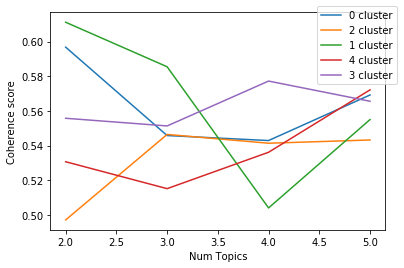

In [70]:
import matplotlib.pyplot as plt
limit=6; start=2; step=1;
x={elem:list(range(start, limit, step)) for elem in (UniqueNames)}
for key in x.keys():
    plt.plot(x[key],coherence_values[key], label= str(key)+ ' cluster') 
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    
plt.legend(loc='best',bbox_to_anchor=(1.05, 1.05))
#plt.show()
plt.savefig('Coherence Sscor.png',bbox_inches='tight')

Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)

In [71]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#### Sentiment Analysis using Textblob

In [72]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk

Create Dataframe dictionary for polarity and subjectivity values vis-a-vis each cluster


In [73]:
polaritycluster={elem : pd.DataFrame for elem in UniqueNames}
subjectivitycluster={elem : pd.DataFrame for elem in UniqueNames}
for i in DataFrameDict.keys():
    polaritycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'].astype('str'))).sentiment.polarity#######################################
    subjectivitycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'].astype('str'))).sentiment.subjectivity################################


Print polarity clusters for each cluster

In [74]:
polaritycluster

{0: 0.08402954068991794,
 2: 0.11008244758278335,
 1: 0.06881752555186713,
 4: -0.01714565871480766,
 3: 0.09684914710895057}

Print subjectivity score for each cluster

In [75]:
subjectivitycluster

{0: 0.44276247651719364,
 2: 0.48407085129128247,
 1: 0.4655121326852915,
 4: 0.450928369306029,
 3: 0.46408677195380793}

Visualize the topics

In [76]:
 #Visualize the topics
pyLDAvis.enable_notebook()
lda_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[1])
vis2 = pyLDAvis.gensim.prepare(lda_model2, corpuscluster[1], dictionarycluster[1])
vis2

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.336978  0.0       1        1  50.815673
1     -0.336978  0.0       2        1  49.184327, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
149   Default  226.000000          afraid  226.000000  30.0000  30.0000
218   Default   80.000000     letter_stun   80.000000  29.0000  29.0000
125   Default   76.000000          report   76.000000  28.0000  28.0000
505   Default   62.000000            ruin   62.000000  27.0000  27.0000
214   Default   62.000000            goal   62.000000  26.0000  26.0000
354   Default   65.000000       treatment   65.000000  25.0000  25.0000
168   Default   60.000000     letter_make   60.000000  24.0000  24.0000
389   Default   57.000000          reason   57.000000  23.0000  23.0000
364   Default   56.000000           black   56.000000  22.0000  22.0000
221   Default   52.000000             lot   52.000000  21.0000  21.0000
75    Default   49.000000          camera   49.000000  20.0000  20.0000
47    Default   48.000000  portray_depart   48.000000  19.0000  19.0000
245   Default   46.000000    wrote_letter   46.000000  18.0000  18.0000
72    Default   46.000000          annual   46.000000  17.0000  17.0000
344   Default   45.000000          lawyer   45.000000  16.0000  16.0000
171   Default   42.000000            mind   42.000000  15.0000  15.0000
359   Default   42.000000           wasnt   42.000000  14.0000  14.0000
249   Default   42.000000          arrest   42.000000  13.0000  13.0000
86    Default   43.000000  convict_murder   43.000000  12.0000  12.0000
120   Default   42.000000          public   42.000000  11.0000  11.0000
209   Default   41.000000        democrat   41.000000  10.0000  10.0000
336   Default   37.000000             due   37.000000   9.0000   9.0000
438   Default   37.000000             bit   37.000000   8.0000   8.0000
216   Default   39.000000            grow   39.000000   7.0000   7.0000
353   Default   39.000000        thriller   39.000000   6.0000   6.0000
165   Default   36.000000             joe   36.000000   5.0000   5.0000
226   Default   37.000000          object   37.000000   4.0000   4.0000
30    Default   36.000000            hood   36.000000   3.0000   3.0000
319   Default   34.000000            solo   34.000000   2.0000   2.0000
468   Default   34.000000            seek   34.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
241    Topic2   11.451531            stun   11.451531   0.7096  -5.5518
246    Topic2   19.467603          afford   19.467603   0.7096  -5.0212
308    Topic2   25.193369          matter   25.193369   0.7096  -4.7633
280    Topic2   11.451531          remark   11.451531   0.7096  -5.5518
505    Topic2   62.983423            ruin   62.983423   0.7096  -3.8470
389    Topic2   57.257657          reason   57.257657   0.7096  -3.9424
75     Topic2   49.241585          camera   49.241585   0.7096  -4.0932
359    Topic2   42.370666           wasnt   42.370666   0.7096  -4.2435
171    Topic2   42.370666            mind   42.370666   0.7096  -4.2435
249    Topic2   42.370666          arrest   42.370666   0.7096  -4.2435
438    Topic2   37.790054             bit   37.790054   0.7096  -4.3579
336    Topic2   37.790054             due   37.790054   0.7096  -4.3579
165    Topic2   36.644901             joe   36.644901   0.7096  -4.3886
468    Topic2   34.354594            seek   34.354594   0.7096  -4.4532
319    Topic2   34.354594            solo   34.354594   0.7096  -4.4532
504    Topic2   32.064288            role   32.064288   0.7096  -4.5222
512    Topic2   30.919135          termin   30.919135   0.7096  -4.5585
388    Topic2   30.919135          racist   30.919135   0.7096  -4.5585
329    Topic2   30.919135             day   30.919135   0.7096  -4.5585
358    Topic2   2

In [77]:
pyLDAvis.save_html(vis2, 'lda1.html') #save the visualization

## 5. Collect and Analyze News articles

In [78]:
# Using newspaper3k package
import newspaper
from newspaper import Article

# for similarity measure
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Sohil\Anaconda3\lib\site-packages\lxml\html\_setmixin.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableSet


We will suggest an article from following three News Service Providers
- CNN
- Washington Post
- New York Times

In [79]:
cnn_paper = newspaper.build('https://www.cnn.com/') #CNN paper
WP_paper = newspaper.build('https://www.washingtonpost.com',language='en') # WP paper 
NYT_paper = newspaper.build('https://www.nytimes.com',language='en') # NYT paper

C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see t

#### Extracting recent articles 

In [110]:
import pandas as pd
df_text = pd.DataFrame(columns=['Link','text'])
for article in cnn_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in WP_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in NYT_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass 

C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)


In [116]:
df_text

,Link,text
0,https://www.cnn.com/2019/04/30/us/california-s...,"(CNN) John T. Earnest, the accused synagogue s..."
1,https://www.cnn.com/2019/04/30/us/sunny-garcia...,"(CNN) Surfing legend Vincent ""Sunny"" Garcia is..."
2,https://www.cnn.com/2019/04/30/us/not-reaching...,(CNN) Jackie Carter knows this shouldn't be an...
3,https://www.cnn.com/2019/04/30/us/seattle-cran...,(CNN) It may be some time before we know for s...
4,https://www.cnn.com/2019/04/30/us/minneapolis-...,Minneapolis (CNN) Former Minneapolis Police Of...
5,https://www.cnn.com/2019/04/30/us/california-s...,(CNN) The man accused in the deadly Chabad of ...
6,https://www.cnn.com/2019/04/30/us/woman-flees-...,(CNN) A woman whose son died after he fell off...
7,https://www.cnn.com/2019/04/30/us/dallas-botha...,(CNN) The former Dallas police officer facing ...
8,https://www.cnn.com/2019/04/30/us/iowa-former-...,(CNN) A 25-year-old Iowa woman was driving hom...
9,https://www.cnn.com/2019/04/30/us/capital-gaze...,(CNN) The man accused of carrying out a killin...


Let's perform cleaning on news articles and for that we can use previous processTweets function which is designed to clean tweets

In [162]:
def processArticles(articles):
    
    #cleaning of articles
    cleanedarticles = []
    for article in articles: 
        article = re.sub("[^a-zA-Z]"," ", str(article))
        article = article.lower() #converting to lowercase letters
        article = ' '.join([word for word in article.split() if word not in (stop)]) #removing stop words
        article = ' '.join([word for word in article.split() if len(word)>2])   
    
        #tokenization
        article = nltk.word_tokenize(article)
    
        #stemming
        article = [ps.stem(word) for word in article]
    
        #lammitization
        article = [wn.lemmatize(word) for word in article]
    
        article = [word for word in article if len(word)>2]
        article = ' '.join(w for w in article if w in words)
    
        cleanedarticles.append(article)
    return cleanedarticles

In [164]:
df_text['text'] = processArticles(df_text['text'])
df_text.head()

,Link,text
0,https://www.cnn.com/2019/04/30/us/california-s...,earnest shooter may sum best told even month a...
1,https://www.cnn.com/2019/04/30/us/sunny-garcia...,surf legend vincent care unit accord world sur...
2,https://www.cnn.com/2019/04/30/us/not-reaching...,carter know perfect world black citizen die tr...
3,https://www.cnn.com/2019/04/30/us/seattle-cran...,may time know sure construct crane come crash ...
4,https://www.cnn.com/2019/04/30/us/minneapolis-...,former found third murder fatal shoot respond ...


In [165]:
df_text['text']

0      earnest shooter may sum best told even month a...
1      surf legend vincent care unit accord world sur...
2      carter know perfect world black citizen die tr...
3      may time know sure construct crane come crash ...
4      former found third murder fatal shoot respond ...
5      man shoot arm legal dress tactic vest five rou...
6      woman whose son die fell scooter ride fled sai...
7      former face murder shoot jean made call say le...
8      year old woman drive home work bullet tore dri...
9      man kill spree plead say suffer mental time la...
10     run accord video post twitter morn singular pl...
11     new york deepen chao could profound global oil...
12     new york stock market fad solid long term bet ...
13     close get subject save problem save descript s...
14     close get subject save problem save descript s...
15     close get subject save problem save descript s...
16     best check tri best town adopt around add new ...
17     beach surfer back water 

Let's find out bigrams and trigrams

In [166]:
docs = array(df_text['text'].apply(lambda x : x.split())) ####################################################################
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [167]:
# Remove rare and common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 510
Number of documents: 190


Let's calculate Sentiment score for news articles

In [168]:
pol=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.polarity for i in range(df_text.shape[0])]
sub=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.subjectivity for i in range(df_text.shape[0])]
df_text['pol']=pol
df_text['sub']=sub

In [169]:
# Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Let's assign topic modelling scores to every news articles for each of the optimal topic model developed

In [170]:
# The percent contribution of each topic model considered as metric to assign topic score
df_topic_sents_keywords={elem : pd.DataFrame for elem in UniqueNames}
topicss=pd.DataFrame()
for i in range(len(UniqueNames)):
    mod=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[i])
    temp={'cluster':i,
         'model':mod}
    topicss=topicss.append(temp, ignore_index=True)
    df_topic_sents_keywords[i] = format_topics_sentences(ldamodel=mod, corpus=corpus, texts=docs)
    
    # Centre the percent contribution by subtracting the mean. This standardises topic score
    df_topic_sents_keywords[i]['Diff']= df_topic_sents_keywords[i]['Perc_Contribution']-np.mean(df_topic_sents_keywords[i]['Perc_Contribution'])

Let's compute sentiment score using cosine similarity between cluster scores and scores obtained from news articles


In [171]:
sentiment={elem: pd.DataFrame for elem in UniqueNames}
subjectivit={elem: pd.DataFrame for elem in UniqueNames}
w1=0.8 # Topic modelling weight
w2=0.2 # Sentiment score weight
for i in range(len(UniqueNames)):
    sentiment[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([polaritycluster[i]]).reshape(-1, 1))
    subjectivit[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([subjectivitycluster[i]]).reshape(-1, 1))
    df_topic_sents_keywords[i]['Polarity']=sentiment[i]
    df_topic_sents_keywords[i]['Subjectivity']=subjectivit[i]
    df_topic_sents_keywords[i]['Metric']=w1*df_topic_sents_keywords[i]['Diff']+w2/2*(df_topic_sents_keywords[i]['Polarity']+df_topic_sents_keywords[i]['Subjectivity'])

## 6. Get user’s Twitter handle & Recommend news articles

In [172]:
# Recommendation dataframe
recommend=pd.DataFrame()
metric_value=pd.DataFrame()
rec=np.array([])
for i in range(len(docs)):
    for j in range(len(UniqueNames)):
        rec=np.append(rec, df_topic_sents_keywords[j].iloc[i,7])
        
    recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
    metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)
    rec=np.array([])

In [173]:
recommend['metric']=metric_value
recommend['url']=df_text['Link']
recommend['article_text']=df_text['text']

#np.array([recommend,metric_value])
recommend #0 is cluster group

,0,metric,url,article_text
0,1.0,0.036902,https://www.cnn.com/2019/04/30/us/california-s...,earnest shooter may sum best told even month a...
1,1.0,0.032022,https://www.cnn.com/2019/04/30/us/sunny-garcia...,surf legend vincent care unit accord world sur...
2,4.0,0.068074,https://www.cnn.com/2019/04/30/us/not-reaching...,carter know perfect world black citizen die tr...
3,0.0,-0.010112,https://www.cnn.com/2019/04/30/us/seattle-cran...,may time know sure construct crane come crash ...
4,2.0,0.047426,https://www.cnn.com/2019/04/30/us/minneapolis-...,former found third murder fatal shoot respond ...
5,3.0,0.044597,https://www.cnn.com/2019/04/30/us/california-s...,man shoot arm legal dress tactic vest five rou...
6,2.0,0.016226,https://www.cnn.com/2019/04/30/us/woman-flees-...,woman whose son die fell scooter ride fled sai...
7,3.0,0.016677,https://www.cnn.com/2019/04/30/us/dallas-botha...,former face murder shoot jean made call say le...
8,2.0,0.002306,https://www.cnn.com/2019/04/30/us/iowa-former-...,year old woman drive home work bullet tore dri...
9,2.0,0.024546,https://www.cnn.com/2019/04/30/us/capital-gaze...,man kill spree plead say suffer mental time la...


In [174]:
recommend.sort_values(by=['metric', 0], ascending ='False')

,0,metric,url,article_text
24,0.0,-0.028032,https://fox11online.com/news/local/brown-count...,
38,0.0,-0.028032,https://www.kptv.com/news/celebrity-chef-volun...,owner
189,1.0,-0.022458,https://www.cnn.com/2019/04/30/motorsport/supe...,latest shield travel pari attend formula race ...
50,0.0,-0.020192,https://www.cnn.com/videos/politics/2019/04/30...,chat find happen world unfold
51,0.0,-0.020192,https://www.cnn.com/videos/us/2019/04/30/bipar...,chat find happen world unfold
53,0.0,-0.020192,https://www.cnn.com/videos/health/2019/04/30/w...,chat find happen world unfold
55,0.0,-0.020192,https://www.cnn.com/videos/health/2019/04/30/1...,chat find happen world unfold
56,0.0,-0.020192,https://www.cnn.com/videos/politics/2019/04/30...,chat find happen world unfold
57,0.0,-0.020192,https://www.cnn.com/videos/politics/2019/04/30...,chat find happen world unfold
13,4.0,-0.016486,https://www.cbs46.com/news/tent-city-growing-i...,close get subject save problem save descript s...


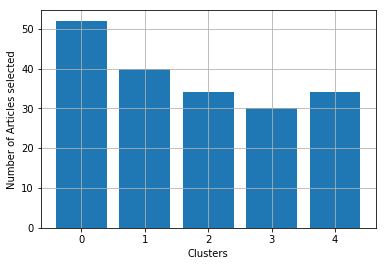

In [175]:
import seaborn as sns
plt.bar(recommend[0].value_counts().index,recommend[0].value_counts())
plt.grid()
plt.xlabel('Clusters')
plt.ylabel('Number of Articles selected')
plt.savefig('Percentage Recommend.png',bbox_inches='tight')

In [176]:
df_topic_sents_keywords

{0:      Dominant_Topic  Perc_Contribution  \
 0               0.0             0.5421   
 1               1.0             0.5149   
 2               1.0             0.5528   
 3               1.0             0.5224   
 4               0.0             0.5450   
 5               0.0             0.5383   
 6               0.0             0.5255   
 7               1.0             0.5412   
 8               1.0             0.5133   
 9               1.0             0.5297   
 10              1.0             0.5319   
 11              0.0             0.5055   
 12              0.0             0.5474   
 13              0.0             0.5091   
 14              0.0             0.5091   
 15              0.0             0.5091   
 16              0.0             0.5066   
 17              0.0             0.5752   
 18              1.0             0.5055   
 19              1.0             0.5153   
 20              0.0             0.5441   
 21              1.0             0.5637   
 22     

In [267]:
def get_jaccard_sim(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [290]:
def GetUserRec(recommend, tweets,cluster):
    articles=recommend[recommend[0]==cluster]    
    articles['corp']= processArticles(articles['article_text'])
    tweetcorp=processTweets(tweets)
#     for i in range(articles.shape[0]):
#         articles.iloc[i,articles.shape[1]]
#         if i==0:
#             jaccard_similar=get_jaccard_sim(tweetcorp,articles.iloc[i,articles.shape[1]])
#         else:
#             jaccard_similar=np.append(jaccard_similar,(get_jaccard_sim(tweetcorp,articles.iloc[i,articles.shape[1]])))
    #article['jaccard_similar']=cosine_similarity(tweetcorp,articles['corp'])
    articles['jaccard']=articles['corp'].apply(lambda x:get_jaccard_sim(tweets,x))
    ranked=articles.sort_values(by=['jaccard'], ascending=False)
    
    return ranked
     
        
        
        
        
    

In [291]:
tweets="I was doing something bad. Donald trump sucks. Sun moon Earth. Java python c program. Something very different"

In [292]:
GetUserRec(recommend,tweets,2)

,0,metric,url,article_text,corp,jaccard
4,2.0,0.047426,https://www.cnn.com/2019/04/30/us/minneapolis-...,former found third murder fatal shoot respond ...,former found third murder fatal shoot respond ...,0.0
139,2.0,0.079986,https://www.cnn.com/2019/04/30/world/spinning-...,light year away earth black hole keep swing je...,light year away earth black hole keep swing je...,0.0
102,2.0,0.034466,http://www.cnn.com/2019/04/30/politics/pompeo-...,state mike claim leader maduro talk russia wat...,state mike claim leader maduro talk russia wat...,0.0
103,2.0,0.019906,https://www.cnn.com/2019/04/30/asia/canada-chi...,hong citizen death china amount chine court ve...,hong citizen death china amount chine court ve...,0.0
109,2.0,0.011026,https://www.cnn.com/2019/04/30/asia/gallery/re...,left wear kimono visit nation garden take phot...,left wear kimono visit nation garden take phot...,0.0
126,2.0,0.010786,https://www.cnn.com/2019/04/30/europe/france-s...,court last eight month hand fine new law seek ...,court last eight month hand fine new law seek ...,0.0
132,2.0,0.015106,https://www.cnn.com/2019/02/26/tech/vr-transfo...,grow number use virtual recruit train staff gi...,grow number use virtual recruit train staff gi...,0.0
137,2.0,0.037426,https://www.cnn.com/travel/article/low-airfare...,seven hour flight across bargain price low cos...,seven hour flight across bargain price low cos...,0.0
157,2.0,0.024386,https://www.cnn.com/2019/04/30/media/game-of-t...,new york game throne notch record million view...,new york game throne notch record million view...,0.0
6,2.0,0.016226,https://www.cnn.com/2019/04/30/us/woman-flees-...,woman whose son die fell scooter ride fled sai...,woman whose son die fell scooter ride fled sai...,0.0


In [243]:
get_jaccard_sim(tweets,recommend['article_text'][25])

0.0